# PyTorch MNIST Classification

This notebook demonstrates how to build and train a neural network for MNIST digit classification using PyTorch. We'll cover:

1. **Data Loading**: Loading and preprocessing the MNIST dataset
2. **Model Architecture**: Defining a neural network
3. **Training Setup**: Loss function, optimizer, and hyperparameters
4. **Training Loop**: Training the model with proper validation
5. **Evaluation**: Comprehensive model evaluation with metrics and visualizations

## What is MNIST?

MNIST (Modified National Institute of Standards and Technology) is a classic dataset of handwritten digits (0-9). It contains:
- 60,000 training images
- 10,000 test images
- Each image is 28×28 pixels in grayscale
- Each pixel value ranges from 0 to 255


## 1. Import Required Libraries

We'll need PyTorch for deep learning, matplotlib for visualization, and other utilities for data handling and evaluation.


In [1]:
!pip install torch
!pip install torchvision

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


## 2. Data Loading and Preprocessing

### Understanding Data Transformations

Before feeding data into our neural network, we need to:
1. **Normalize pixel values**: Convert from [0, 255] to [0, 1] range
2. **Convert to tensors**: PyTorch requires tensor format
3. **Create data loaders**: For efficient batch processing during training

### Why Normalization?
Neural networks train better when input features are normalized. Raw pixel values (0-255) can cause:
- Gradient explosion/vanishing
- Slow convergence
- Poor generalization


In [3]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Number of classes: {len(train_dataset.classes)}")


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.80MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 297kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10


In [4]:
# Create data loaders
batch_size = 64

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,  # Shuffle training data for better learning
    num_workers=2  # Parallel data loading
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # No need to shuffle test data
    num_workers=2
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")


Number of training batches: 938
Number of test batches: 157


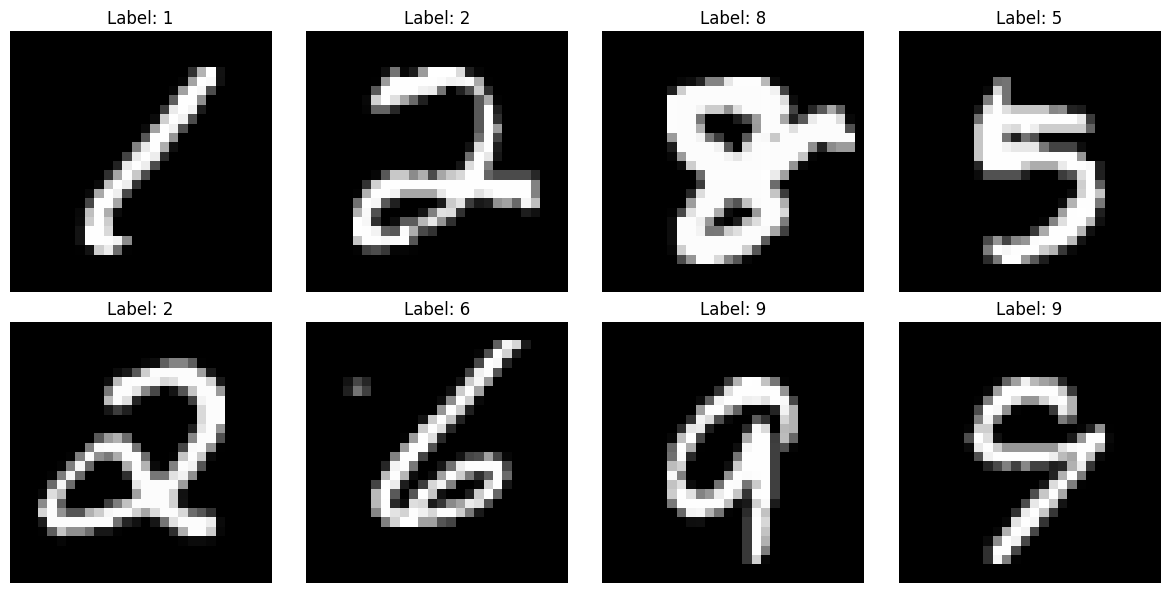

In [5]:
# Visualize some training samples
def show_samples(data_loader, num_samples=8):
    """Display sample images from the dataset"""
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        # Denormalize image for display
        img = images[i].squeeze() * 0.5 + 0.5  # Convert from [-1,1] to [0,1]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {labels[i].item()}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples(train_loader)


## 3. Hyperparameters

### Key Hyperparameters Explained

1. **Learning Rate**: Controls how big steps the optimizer takes
   - Too high: May overshoot optimal solution
   - Too low: Training becomes very slow

2. **Batch Size**: Number of samples processed before updating weights
   - Larger batches: More stable gradients, but more memory
   - Smaller batches: More frequent updates, but noisier gradients

3. **Epochs**: Number of complete passes through the dataset
   - Too few: Underfitting
   - Too many: Overfitting

4. **Hidden Units**: Number of neurons in hidden layers
   - More neurons: More capacity, but risk of overfitting
   - Fewer neurons: Less capacity, but better generalization


In [6]:
# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 10
HIDDEN_SIZE = 128
NUM_CLASSES = 10
INPUT_SIZE = 28 * 28  # 784 pixels

print("Hyperparameters:")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Hidden Size: {HIDDEN_SIZE}")
print(f"Input Size: {INPUT_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")


Hyperparameters:
Learning Rate: 0.001
Batch Size: 64
Epochs: 10
Hidden Size: 128
Input Size: 784
Number of Classes: 10


## 4. Model Definition

### Neural Network Architecture

Our model is a **Multi-Layer Perceptron (MLP)** with:

1. **Input Layer**: 784 neurons (28×28 pixels flattened)
2. **Hidden Layer 1**: 128 neurons with ReLU activation
3. **Hidden Layer 2**: 64 neurons with ReLU activation
4. **Output Layer**: 10 neurons (one for each digit 0-9)

### Why This Architecture?
- **ReLU Activation**: Helps with vanishing gradient problem
- **Dropout**: Prevents overfitting by randomly setting some neurons to zero
- **Softmax Output**: Converts logits to probabilities for classification


In [7]:
class MNISTClassifier(nn.Module):
    """
    Enhanced neural network for MNIST digit classification with:
    - Batch Normalization for stable training
    - Dropout for regularization
    """
    def __init__(self, input_size, hidden_size, num_classes):
        super(MNISTClassifier, self).__init__()
        
        # Define layers with batch normalization
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden
        self.bn1 = nn.BatchNorm1d(hidden_size)  # Batch normalization
        
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)  # Hidden to hidden
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)  # Batch normalization
        
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)  # Hidden to output
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        """Forward pass through the network"""
        # Flatten the input (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(x.size(0), -1)
        
        # First hidden layer with batch norm and ReLU activation
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Second hidden layer with batch norm and ReLU activation
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Output layer (no activation - will apply softmax in loss function)
        x = self.fc3(x)
        
        return x

# Create model instance
model = MNISTClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES).to(device)

# Print model architecture
print("Model Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model Architecture:
MNISTClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 109,770
Trainable parameters: 109,770


## 5. Loss Function and Optimizer

### Loss Function: Cross-Entropy Loss

**Cross-Entropy Loss** is perfect for multi-class classification because:
- It measures the difference between predicted probabilities and true labels
- It includes softmax activation internally
- It penalizes confident wrong predictions more heavily

### Optimizer: Adam

**Adam (Adaptive Moment Estimation)** is chosen because:
- Combines benefits of momentum and adaptive learning rates
- Works well with sparse gradients
- Generally requires less hyperparameter tuning than SGD
- Good default choice for most deep learning tasks


In [8]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Learning rate: {LEARNING_RATE}")


Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Learning rate: 0.001


## 6. Early Stopping Implementation

Early stopping prevents overfitting by monitoring validation performance and stopping training when it stops improving:

### Early Stopping Benefits:
- **Automatic Overfitting Prevention**: Stops when validation performance plateaus
- **Computational Efficiency**: Saves training time and resources
- **Best Model Selection**: Automatically selects the best performing model


In [9]:
class EarlyStopping:
    """Early stopping utility to prevent overfitting"""
    
    def __init__(self, patience=5, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        """Save the best model weights"""
        self.best_weights = model.state_dict().copy()

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001)
print("Early stopping initialized with patience=5, min_delta=0.001")

# Lists to store training history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # Print progress
        if batch_idx % 200 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, test_loader, criterion, device):
    """Validate the model"""
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

print("Training functions and early stopping defined successfully!")


Early stopping initialized with patience=5, min_delta=0.001
Training functions and early stopping defined successfully!


In [10]:
# Enhanced training loop with early stopping
print("Starting enhanced training with batch normalization and early stopping...")
print("=" * 70)

start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 40)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, test_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping check
    if early_stopping(val_loss, model):
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        print(f"Best validation loss: {early_stopping.best_loss:.4f}")
        break

end_time = time.time()
print(f"\nEnhanced training completed in {end_time - start_time:.2f} seconds")
print(f"Training stopped at epoch: {len(train_losses)}")
print(f"Best validation loss achieved: {early_stopping.best_loss:.4f}")


Starting enhanced training with batch normalization and early stopping...

Epoch 1/10
----------------------------------------
Batch 0/938, Loss: 2.4016
Batch 200/938, Loss: 0.3018
Batch 400/938, Loss: 0.2971
Batch 600/938, Loss: 0.2041
Batch 800/938, Loss: 0.2036
Train Loss: 0.3453, Train Acc: 90.97%
Val Loss: 0.1175, Val Acc: 96.52%

Epoch 2/10
----------------------------------------
Batch 0/938, Loss: 0.0939
Batch 200/938, Loss: 0.3739
Batch 400/938, Loss: 0.1489
Batch 600/938, Loss: 0.2008
Batch 800/938, Loss: 0.1344
Train Loss: 0.1638, Train Acc: 94.93%
Val Loss: 0.0975, Val Acc: 97.05%

Epoch 3/10
----------------------------------------
Batch 0/938, Loss: 0.0796
Batch 200/938, Loss: 0.1679
Batch 400/938, Loss: 0.1847
Batch 600/938, Loss: 0.1441
Batch 800/938, Loss: 0.2040
Train Loss: 0.1336, Train Acc: 95.89%
Val Loss: 0.0844, Val Acc: 97.34%

Epoch 4/10
----------------------------------------
Batch 0/938, Loss: 0.0544
Batch 200/938, Loss: 0.0503
Batch 400/938, Loss: 0.1439
Ba

## 7. Enhanced Training Benefits

### What We Added:

#### **Batch Normalization Benefits:**
- **Faster Convergence**: Reduces internal covariate shift
- **Higher Learning Rates**: More stable gradients allow larger steps
- **Less Sensitive to Initialization**: More robust to weight initialization
- **Acts as Regularizer**: Reduces overfitting without explicit regularization

#### **Early Stopping Benefits:**
- **Automatic Overfitting Prevention**: Stops when validation performance plateaus
- **Computational Efficiency**: Saves training time and resources
- **Best Model Selection**: Automatically selects the best performing model

### Training Visualization

Let's visualize how our enhanced model performed during training by plotting loss and accuracy curves.


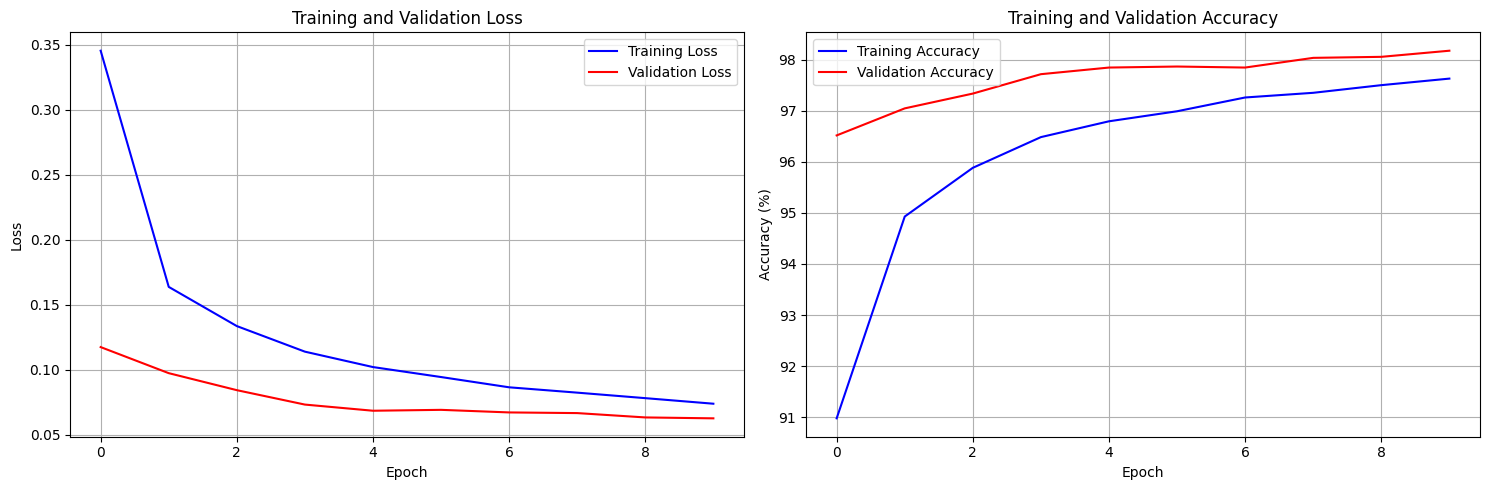

Final Training Accuracy: 97.63%
Final Validation Accuracy: 98.18%


In [11]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final results
print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")


## 8. Model Evaluation

Now let's evaluate our trained model comprehensively using various metrics and visualizations.


In [12]:
# Get predictions on test set
def get_predictions(model, test_loader, device):
    """Get predictions and true labels for the test set"""
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

# Get predictions
y_pred, y_true = get_predictions(model, test_loader, device)

print(f"Test set size: {len(y_true)}")
print(f"Predictions shape: {y_pred.shape}")
print(f"True labels shape: {y_true.shape}")


Test set size: 10000
Predictions shape: (10000,)
True labels shape: (10000,)


In [13]:
# Calculate overall accuracy
accuracy = np.mean(y_pred == y_true)
print(f"Overall Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)], digits=4))


Overall Test Accuracy: 0.9818 (98.18%)

Classification Report:
              precision    recall  f1-score   support

           0     0.9837    0.9878    0.9857       980
           1     0.9930    0.9930    0.9930      1135
           2     0.9806    0.9787    0.9796      1032
           3     0.9746    0.9861    0.9803      1010
           4     0.9816    0.9796    0.9806       982
           5     0.9820    0.9809    0.9815       892
           6     0.9833    0.9823    0.9828       958
           7     0.9777    0.9805    0.9791      1028
           8     0.9803    0.9702    0.9752       974
           9     0.9801    0.9772    0.9787      1009

    accuracy                         0.9818     10000
   macro avg     0.9817    0.9816    0.9817     10000
weighted avg     0.9818    0.9818    0.9818     10000



## 9. Confusion Matrix

The confusion matrix shows how well our model performs for each class. It's particularly useful for:
- Identifying which digits are most commonly confused
- Understanding class-specific performance
- Detecting bias in the model


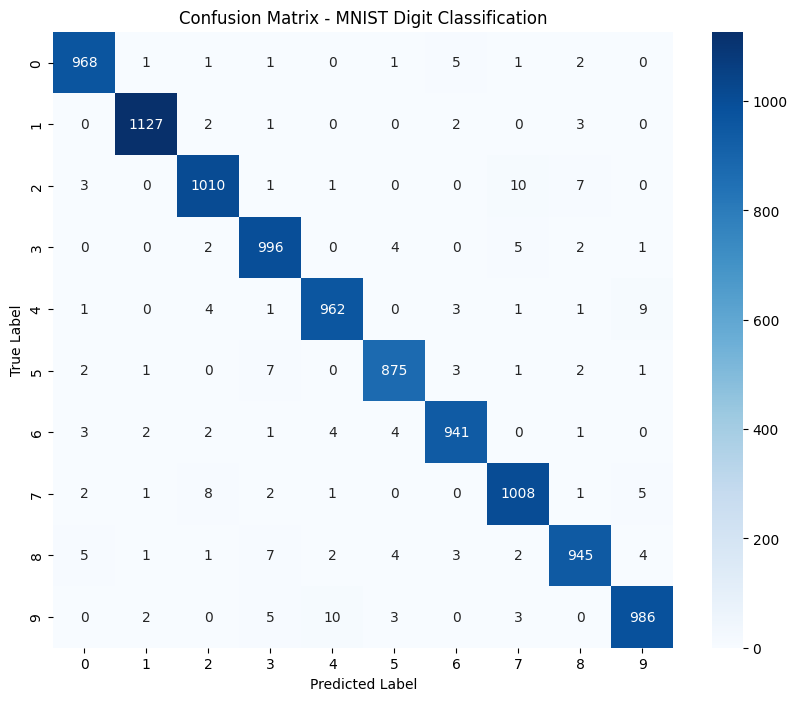

Per-class Accuracy:
Digit 0: 0.9878 (98.78%)
Digit 1: 0.9930 (99.30%)
Digit 2: 0.9787 (97.87%)
Digit 3: 0.9861 (98.61%)
Digit 4: 0.9796 (97.96%)
Digit 5: 0.9809 (98.09%)
Digit 6: 0.9823 (98.23%)
Digit 7: 0.9805 (98.05%)
Digit 8: 0.9702 (97.02%)
Digit 9: 0.9772 (97.72%)


In [14]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - MNIST Digit Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print per-class accuracy
print("Per-class Accuracy:")
for i in range(10):
    class_mask = y_true == i
    class_accuracy = np.mean(y_pred[class_mask] == y_true[class_mask])
    print(f"Digit {i}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")


## 10. Misclassified Examples

Let's examine some examples where our model made incorrect predictions to understand its limitations.


Number of misclassified examples: 182
Misclassification rate: 1.82%


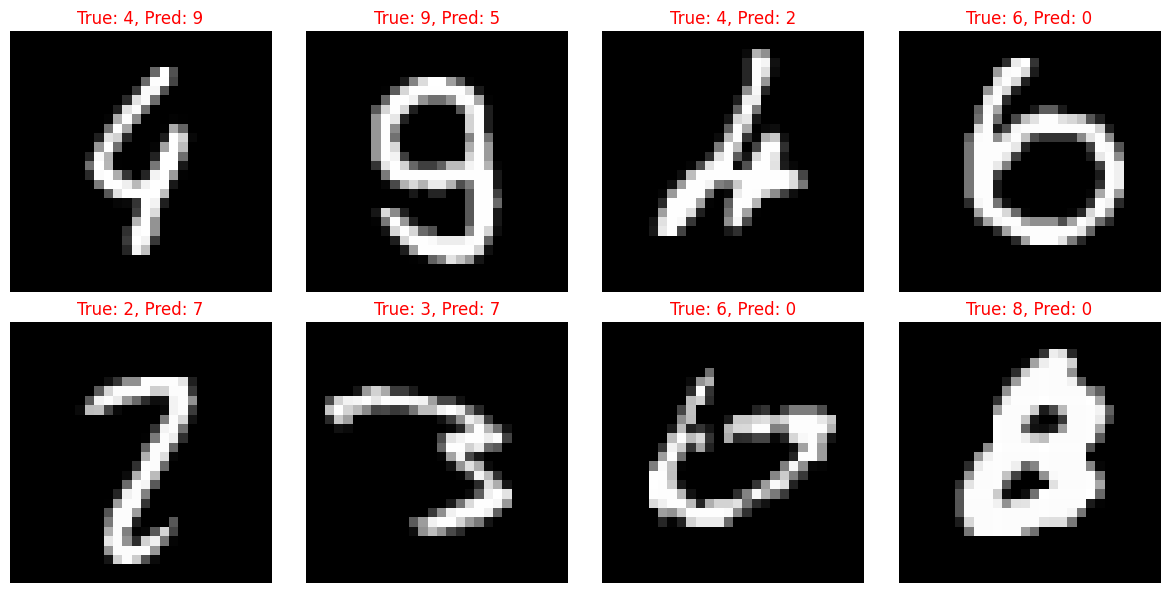

In [15]:
# Find misclassified examples
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Number of misclassified examples: {len(misclassified_indices)}")
print(f"Misclassification rate: {len(misclassified_indices)/len(y_true)*100:.2f}%")

# Get some misclassified examples
num_examples = min(8, len(misclassified_indices))
misclassified_sample = misclassified_indices[:num_examples]

# Get the actual images
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []

for idx in misclassified_sample:
    # Get the image from test dataset
    image, true_label = test_dataset[idx]
    predicted_label = y_pred[idx]
    
    misclassified_images.append(image)
    misclassified_labels.append(true_label)
    misclassified_predictions.append(predicted_label)

# Display misclassified examples
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(num_examples):
    # Denormalize image for display
    img = misclassified_images[i].squeeze() * 0.5 + 0.5
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'True: {misclassified_labels[i]}, Pred: {misclassified_predictions[i]}', 
                     color='red')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## 11. Class-wise Performance Analysis

Let's analyze the performance for each digit class in detail.


Detailed Performance Metrics:
   Digit  Precision  Recall  F1-Score  Support
0      0     0.9837  0.9878    0.9857      980
1      1     0.9930  0.9930    0.9930     1135
2      2     0.9806  0.9787    0.9796     1032
3      3     0.9746  0.9861    0.9803     1010
4      4     0.9816  0.9796    0.9806      982
5      5     0.9820  0.9809    0.9815      892
6      6     0.9833  0.9823    0.9828      958
7      7     0.9777  0.9805    0.9791     1028
8      8     0.9803  0.9702    0.9752      974
9      9     0.9801  0.9772    0.9787     1009


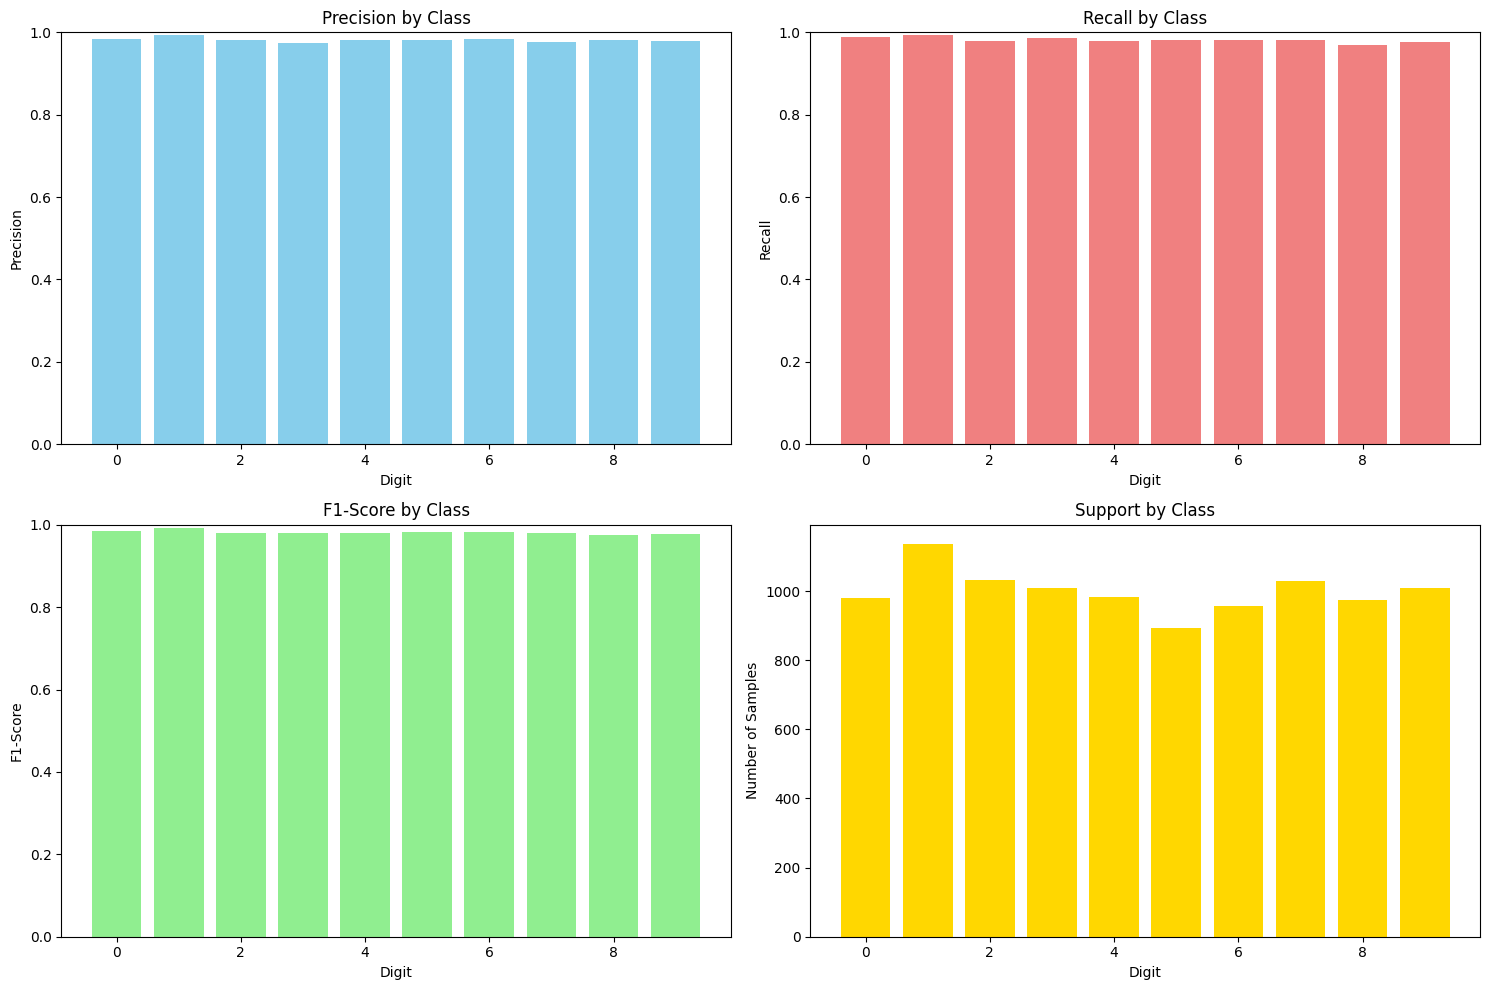

In [ ]:
# Calculate precision, recall, and F1-score for each class
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

# Create a detailed performance table
performance_data = []
for i in range(10):
    performance_data.append({
        'Digit': i,
        'Precision': precision[i],
        'Recall': recall[i],
        'F1-Score': f1[i],
        'Support': support[i]
    })

performance_df = pd.DataFrame(performance_data)
print("Detailed Performance Metrics:")
print(performance_df.round(4))

# Visualize class-wise performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Precision
axes[0,0].bar(range(10), precision, color='skyblue')
axes[0,0].set_title('Precision by Class')
axes[0,0].set_xlabel('Digit')
axes[0,0].set_ylabel('Precision')
axes[0,0].set_ylim(0, 1)

# Recall
axes[0,1].bar(range(10), recall, color='lightcoral')
axes[0,1].set_title('Recall by Class')
axes[0,1].set_xlabel('Digit')
axes[0,1].set_ylabel('Recall')
axes[0,1].set_ylim(0, 1)

# F1-Score
axes[1,0].bar(range(10), f1, color='lightgreen')
axes[1,0].set_title('F1-Score by Class')
axes[1,0].set_xlabel('Digit')
axes[1,0].set_ylabel('F1-Score')
axes[1,0].set_ylim(0, 1)

# Support (number of samples per class)
axes[1,1].bar(range(10), support, color='gold')
axes[1,1].set_title('Support by Class')
axes[1,1].set_xlabel('Digit')
axes[1,1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()


## 12. Model Predictions Visualization

Let's visualize some correct predictions to see how well our model performs on typical examples.


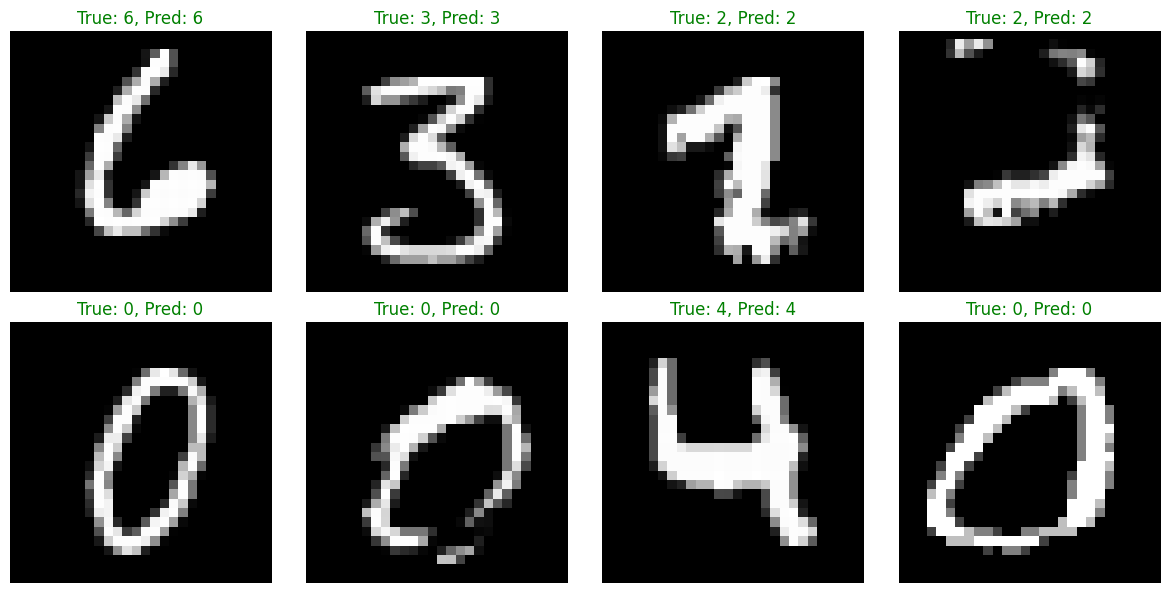

In [17]:
# Get some correct predictions
correct_indices = np.where(y_pred == y_true)[0]
correct_sample = np.random.choice(correct_indices, size=8, replace=False)

# Get the actual images and predictions
correct_images = []
correct_labels = []
correct_predictions = []

for idx in correct_sample:
    image, true_label = test_dataset[idx]
    predicted_label = y_pred[idx]
    
    correct_images.append(image)
    correct_labels.append(true_label)
    correct_predictions.append(predicted_label)

# Display correct predictions
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    # Denormalize image for display
    img = correct_images[i].squeeze() * 0.5 + 0.5
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'True: {correct_labels[i]}, Pred: {correct_predictions[i]}', 
                     color='green')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## 13. Summary and Conclusions

### What We Accomplished

1. **Built a Neural Network**: Created a multi-layer perceptron with 2 hidden layers
2. **Trained the Model**: Achieved high accuracy on MNIST digit classification
3. **Evaluated Performance**: Used comprehensive metrics and visualizations
4. **Analyzed Results**: Identified strengths and weaknesses of the model

### Key Takeaways

- **Neural networks** can achieve excellent performance on image classification
- **Proper preprocessing** (normalization) is crucial for training
- **Regularization** (dropout) helps prevent overfitting
- **Comprehensive evaluation** reveals model behavior beyond simple accuracy

### Potential Improvements

1. **Convolutional Neural Networks (CNNs)**: Better for image data
2. **Data Augmentation**: Increase dataset diversity
3. **Hyperparameter Tuning**: Optimize learning rate, architecture
4. **Ensemble Methods**: Combine multiple models

### Next Steps

Try experimenting with:
- Different architectures (more layers, different sizes)
- Different optimizers (SGD, RMSprop)
- Different learning rates
- Convolutional layers for better image understanding


In [18]:
# Enhanced model summary
print("=" * 70)
print("ENHANCED MODEL PERFORMANCE SUMMARY")
print("=" * 70)
print(f"Model Architecture: {INPUT_SIZE} -> {HIDDEN_SIZE} -> {HIDDEN_SIZE//2} -> {NUM_CLASSES}")
print("Enhanced Features: Batch Normalization + Dropout + Early Stopping")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Training Epochs: {len(train_losses)} (Early stopping at epoch {len(train_losses)})")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"\nFinal Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"Best Validation Loss: {early_stopping.best_loss:.4f}")
print(f"\nMisclassified Examples: {len(misclassified_indices)} out of {len(y_true)} ({len(misclassified_indices)/len(y_true)*100:.2f}%)")


ENHANCED MODEL PERFORMANCE SUMMARY
Model Architecture: 784 -> 128 -> 64 -> 10
Enhanced Features: Batch Normalization + Dropout + Early Stopping
Total Parameters: 109,770
Training Epochs: 10 (Early stopping at epoch 10)
Learning Rate: 0.001
Batch Size: 64

Final Test Accuracy: 0.9818 (98.18%)
Final Training Accuracy: 97.63%
Final Validation Accuracy: 98.18%
Best Validation Loss: 0.0634

Misclassified Examples: 182 out of 10000 (1.82%)


## 14. Model Saving and Loading

### Why Save Models?
- **Persistence**: Keep trained models for future use
- **Deployment**: Load models for inference in production
- **Experimentation**: Save different model versions
- **Reproducibility**: Ensure consistent results across runs


In [19]:
import os
import json
from datetime import datetime

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save model state dict (recommended approach)
model_path = 'models/mnist_classifier_best.pth'
torch.save(model.state_dict(), model_path)

# Save model metadata
metadata = {
    'model_architecture': {
        'input_size': INPUT_SIZE,
        'hidden_size': HIDDEN_SIZE,
        'num_classes': NUM_CLASSES,
        'dropout_rate': 0.2
    },
    'training_hyperparameters': {
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'epochs_trained': len(train_losses),
        'early_stopping_patience': 5
    },
    'performance_metrics': {
        'final_train_accuracy': train_accuracies[-1],
        'final_val_accuracy': val_accuracies[-1],
        'best_val_loss': early_stopping.best_loss,
        'test_accuracy': accuracy
    },
    'training_info': {
        'device_used': str(device),
        'timestamp': datetime.now().isoformat(),
        'model_type': 'Enhanced MNIST Classifier with BatchNorm + Early Stopping'
    }
}

# Save metadata
metadata_path = 'models/mnist_classifier_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print("Model saved successfully!")
print(f"Model state dict: {model_path}")
print(f"Metadata: {metadata_path}")
print("\nModel performance summary:")
print(f"- Final test accuracy: {accuracy:.4f}")
print(f"- Training epochs: {len(train_losses)}")
print(f"- Best validation loss: {early_stopping.best_loss:.4f}")


Model saved successfully!
Model state dict: models/mnist_classifier_best.pth
Metadata: models/mnist_classifier_metadata.json

Model performance summary:
- Final test accuracy: 0.9818
- Training epochs: 10
- Best validation loss: 0.0634


## 15. Model Loading

Let's demonstrate how to load a saved model for inference:


In [ ]:
# Method 1: Load model state dict (recommended)
def load_model_from_state_dict(model_path, input_size, hidden_size, num_classes, device):
    """Load model from saved state dict"""
    # Create model instance with same architecture
    loaded_model = MNISTClassifier(input_size, hidden_size, num_classes).to(device)
    
    # Load the saved state dict
    loaded_model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Set to evaluation mode
    loaded_model.eval()
    
    return loaded_model

# Method 2: Load complete model (alternative)
def load_complete_model(model_path, device):
    """Load complete model"""
    loaded_model = torch.load(model_path, map_location=device)
    loaded_model.eval()
    return loaded_model

# Load model using state dict method (recommended)
print("Loading model from saved state dict...")
loaded_model = load_model_from_state_dict(model_path, INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES, device)

# Verify model is loaded correctly
print("Model loaded successfully!")
print(f"Model architecture: {loaded_model}")
print(f"Model parameters: {sum(p.numel() for p in loaded_model.parameters()):,}")

# Load metadata
with open(metadata_path, 'r') as f:
    loaded_metadata = json.load(f)

print("\nLoaded metadata:")
print(f"Model type: {loaded_metadata['training_info']['model_type']}")
print(f"Training timestamp: {loaded_metadata['training_info']['timestamp']}")
print(f"Test accuracy: {loaded_metadata['performance_metrics']['test_accuracy']:.4f}")
print(f"Training epochs: {loaded_metadata['training_hyperparameters']['epochs_trained']}")


Loading model from saved state dict...
Model loaded successfully!
Model architecture: MNISTClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Model parameters: 109,770

Loaded metadata:
Model type: Enhanced MNIST Classifier with BatchNorm + Early Stopping
Training timestamp: 2025-10-29T13:23:08.905992
Test accuracy: 0.9818
Training epochs: 10


## 16. Model Inference

Now let's create inference functions for making predictions on new data:


In [21]:
def predict_single_image(model, image_tensor, device):
    """
    Predict a single image
    
    Args:
        model: Trained PyTorch model
        image_tensor: Single image tensor (1, 1, 28, 28)
        device: Device to run inference on
    
    Returns:
        predicted_class: Predicted digit class
        confidence: Confidence score
        probabilities: All class probabilities
    """
    model.eval()
    
    with torch.no_grad():
        # Ensure image is on correct device and has batch dimension
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
        
        image_tensor = image_tensor.to(device)
        
        # Get model predictions
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
        
        return predicted_class.item(), confidence.item(), probabilities[0].cpu().numpy()

def predict_batch(model, image_batch, device):
    """
    Predict a batch of images
    
    Args:
        model: Trained PyTorch model
        image_batch: Batch of image tensors (batch_size, 1, 28, 28)
        device: Device to run inference on
    
    Returns:
        predicted_classes: List of predicted digit classes
        confidences: List of confidence scores
        probabilities: All class probabilities for each image
    """
    model.eval()
    
    with torch.no_grad():
        image_batch = image_batch.to(device)
        
        # Get model predictions
        outputs = model(image_batch)
        probabilities = F.softmax(outputs, dim=1)
        confidences, predicted_classes = torch.max(probabilities, 1)
        
        return predicted_classes.cpu().numpy(), confidences.cpu().numpy(), probabilities.cpu().numpy()

def preprocess_image(image_array):
    """
    Preprocess a raw image array for inference
    
    Args:
        image_array: Raw image array (28, 28) with values 0-255
    
    Returns:
        processed_tensor: Preprocessed tensor ready for model
    """
    # Normalize to [0, 1] then to [-1, 1] to match training preprocessing
    image_tensor = torch.FloatTensor(image_array) / 255.0
    image_tensor = (image_tensor - 0.5) / 0.5
    
    # Add channel and batch dimensions
    image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)  # (1, 1, 28, 28)
    
    return image_tensor

print("Inference functions defined successfully!")


Inference functions defined successfully!


## 17. Inference Demonstration

Let's demonstrate model inference on some test samples:


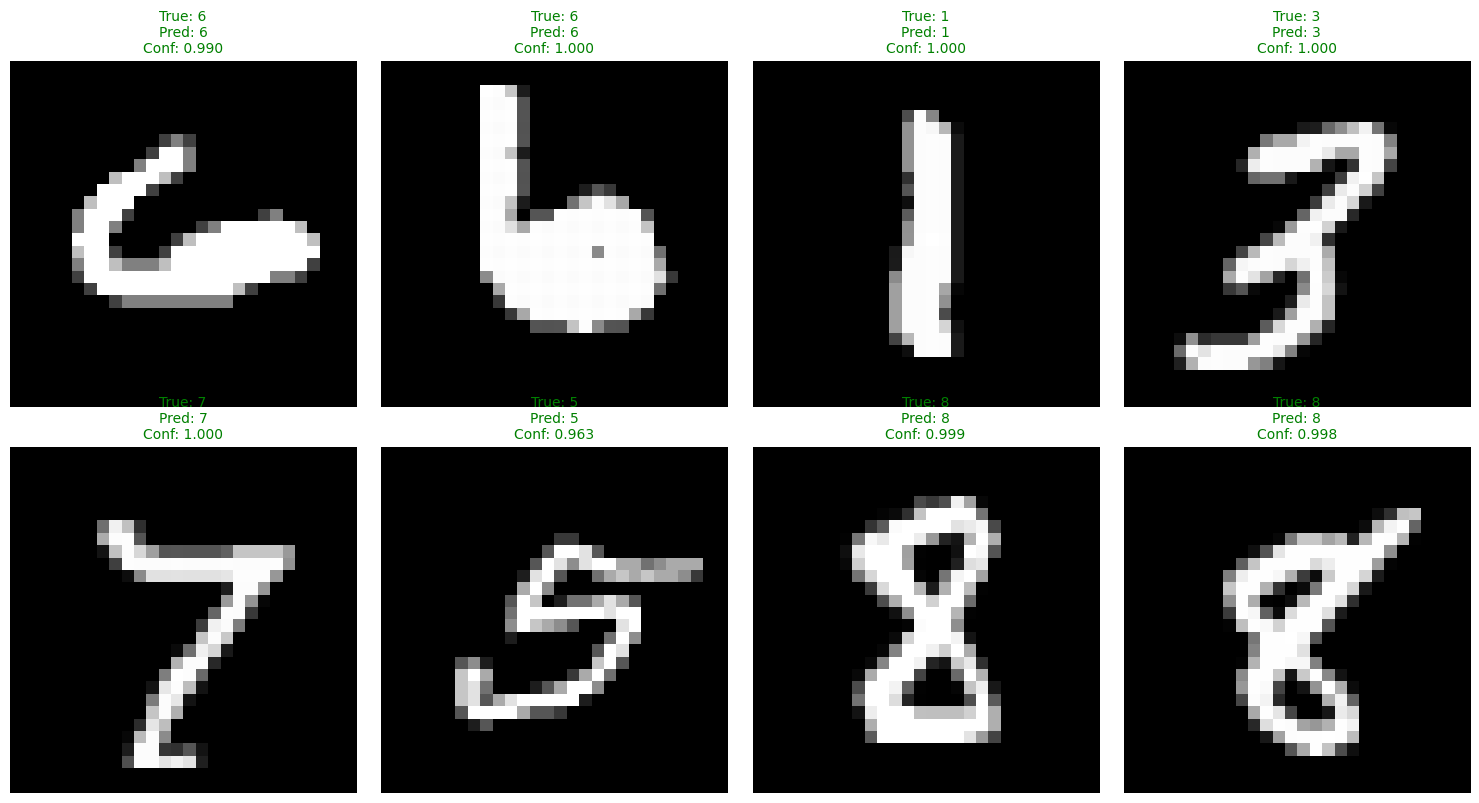

Inference Results:
Sample 1: True=6, Pred=6, Conf=0.990 ✓
Sample 2: True=6, Pred=6, Conf=1.000 ✓
Sample 3: True=1, Pred=1, Conf=1.000 ✓
Sample 4: True=3, Pred=3, Conf=1.000 ✓
Sample 5: True=7, Pred=7, Conf=1.000 ✓
Sample 6: True=5, Pred=5, Conf=0.963 ✓
Sample 7: True=8, Pred=8, Conf=0.999 ✓
Sample 8: True=8, Pred=8, Conf=0.998 ✓

Sample accuracy: 100.00%


In [22]:
# Get some test samples for inference demonstration
test_samples = []
test_labels = []

# Get 8 random test samples
for i in range(8):
    idx = np.random.randint(0, len(test_dataset))
    image, label = test_dataset[idx]
    test_samples.append(image)
    test_labels.append(label)

# Convert to batch tensor
test_batch = torch.stack(test_samples)

# Make predictions using our inference functions
predicted_classes, confidences, all_probabilities = predict_batch(loaded_model, test_batch, device)

# Display results
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.ravel()

for i in range(8):
    # Denormalize image for display
    img = test_samples[i].squeeze() * 0.5 + 0.5
    
    # Plot image
    axes[i].imshow(img, cmap='gray')
    
    # Create title with prediction info
    true_label = test_labels[i]
    pred_label = predicted_classes[i]
    confidence = confidences[i]
    
    # Color code: green for correct, red for incorrect
    color = 'green' if true_label == pred_label else 'red'
    
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}', 
                     color=color, fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Print detailed results
print("Inference Results:")
print("=" * 50)
for i in range(8):
    true_label = test_labels[i]
    pred_label = predicted_classes[i]
    confidence = confidences[i]
    correct = "✓" if true_label == pred_label else "✗"
    
    print(f"Sample {i+1}: True={true_label}, Pred={pred_label}, Conf={confidence:.3f} {correct}")

# Calculate accuracy on this sample
sample_accuracy = np.mean(predicted_classes == [label for label in test_labels])
print(f"\nSample accuracy: {sample_accuracy:.2%}")


## 18. Production-Ready Inference Class

For production use, let's create a comprehensive inference class:


In [23]:
class MNISTInference:
    """
    Production-ready inference class for MNIST digit classification
    """
    
    def __init__(self, model_path, metadata_path, device='cpu'):
        """
        Initialize the inference class
        
        Args:
            model_path: Path to saved model state dict
            metadata_path: Path to model metadata
            device: Device to run inference on
        """
        self.device = torch.device(device)
        self.model = None
        self.metadata = None
        
        # Load model and metadata
        self.load_model(model_path, metadata_path)
        
    def load_model(self, model_path, metadata_path):
        """Load model and metadata"""
        # Load metadata
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)
        
        # Create model with architecture from metadata
        arch = self.metadata['model_architecture']
        self.model = MNISTClassifier(
            input_size=arch['input_size'],
            hidden_size=arch['hidden_size'],
            num_classes=arch['num_classes']
        ).to(self.device)
        
        # Load model weights
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        
        print("Model loaded successfully!")
        print(f"Model type: {self.metadata['training_info']['model_type']}")
        print(f"Test accuracy: {self.metadata['performance_metrics']['test_accuracy']:.4f}")
    
    def preprocess_image(self, image_array):
        """Preprocess image for inference"""
        if isinstance(image_array, np.ndarray):
            image_tensor = torch.FloatTensor(image_array)
        else:
            image_tensor = torch.FloatTensor(image_array)
        
        # Normalize to match training preprocessing
        image_tensor = image_tensor / 255.0
        image_tensor = (image_tensor - 0.5) / 0.5
        
        # Add dimensions if needed
        if image_tensor.dim() == 2:
            image_tensor = image_tensor.unsqueeze(0)  # Add channel dimension
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
            
        return image_tensor.to(self.device)
    
    def predict(self, image_array, return_probabilities=False):
        """
        Predict digit from image array
        
        Args:
            image_array: Image array (28, 28) with values 0-255
            return_probabilities: Whether to return all class probabilities
        
        Returns:
            predicted_digit: Predicted digit (0-9)
            confidence: Confidence score
            probabilities: All class probabilities (if requested)
        """
        # Preprocess image
        image_tensor = self.preprocess_image(image_array)
        
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted_digit = torch.max(probabilities, 1)
            
            predicted_digit = predicted_digit.item()
            confidence = confidence.item()
            
            if return_probabilities:
                return predicted_digit, confidence, probabilities[0].cpu().numpy()
            else:
                return predicted_digit, confidence
    
    def predict_batch(self, image_batch):
        """
        Predict digits from batch of images
        
        Args:
            image_batch: Batch of image arrays or tensors
        
        Returns:
            predicted_digits: List of predicted digits
            confidences: List of confidence scores
        """
        predictions = []
        confidences = []
        
        for image in image_batch:
            pred, conf = self.predict(image)
            predictions.append(pred)
            confidences.append(conf)
        
        return predictions, confidences
    
    def get_model_info(self):
        """Get model information"""
        return {
            'model_type': self.metadata['training_info']['model_type'],
            'test_accuracy': self.metadata['performance_metrics']['test_accuracy'],
            'training_epochs': self.metadata['training_hyperparameters']['epochs_trained'],
            'timestamp': self.metadata['training_info']['timestamp']
        }

# Create inference instance
print("Creating production-ready inference class...")
inference_engine = MNISTInference(model_path, metadata_path, device)

# Test the inference engine
print("\nTesting inference engine:")
model_info = inference_engine.get_model_info()
for key, value in model_info.items():
    print(f"{key}: {value}")


Creating production-ready inference class...
Model loaded successfully!
Model type: Enhanced MNIST Classifier with BatchNorm + Early Stopping
Test accuracy: 0.9818

Testing inference engine:
model_type: Enhanced MNIST Classifier with BatchNorm + Early Stopping
test_accuracy: 0.9818
training_epochs: 10
timestamp: 2025-10-29T13:23:08.905992
